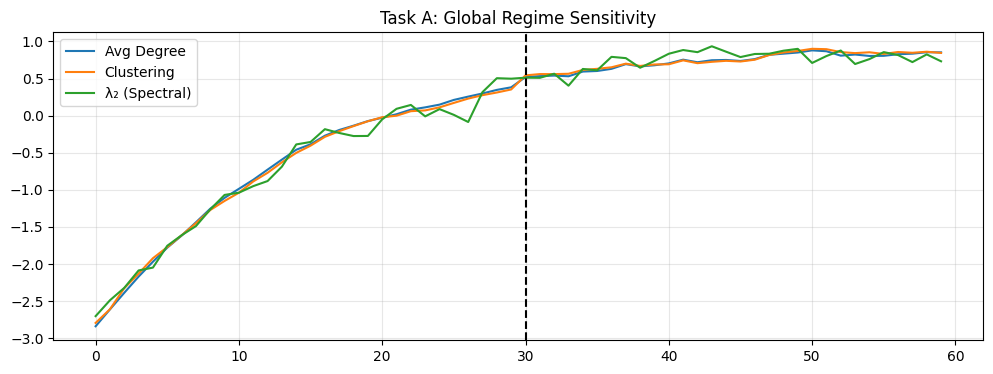

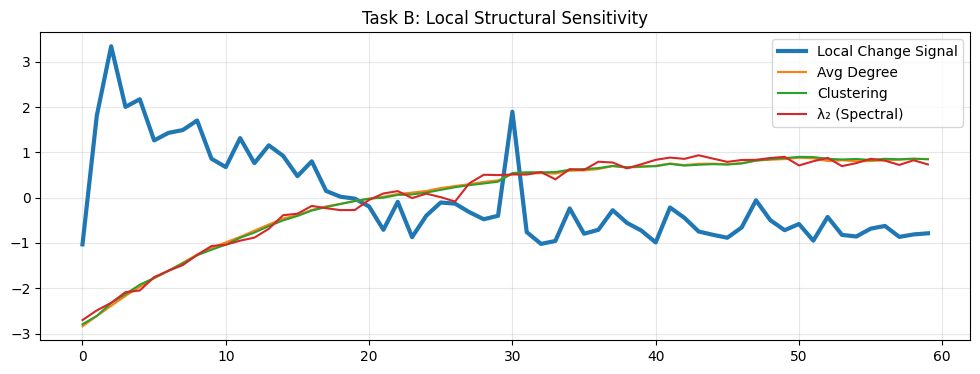

In [1]:
# ============================================
# Task-Relativity of Emergent Representations
# ============================================

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# -----------------------
# Parameters
# -----------------------
N = 100
T = 60
p_noise = 0.015
regime_change_t = 30

# -----------------------
# Initial graph: community structure
# -----------------------
G = nx.stochastic_block_model(
    sizes=[50, 50],
    p=[[0.12, 0.01],
       [0.01, 0.12]]
)

# -----------------------
# Storage
# -----------------------
avg_degree = []
clustering = []
lambda2 = []

# Task labels
global_regime = []      # Task A target
local_change = []       # Task B target

# -----------------------
# Simulation
# -----------------------
prev_clustering = None

for t in range(T):

    # Random edge noise
    for _ in range(int(p_noise * N * N)):
        u, v = np.random.randint(0, N, size=2)
        if u != v:
            if G.has_edge(u, v):
                G.remove_edge(u, v)
            else:
                G.add_edge(u, v)

    # Regime change
    if t == regime_change_t:
        avg_deg = np.mean([d for _, d in G.degree()])
        p = avg_deg / (N - 1)
        G = nx.erdos_renyi_graph(N, p)

    # ---- Summaries ----
    degs = [d for _, d in G.degree()]
    avg_degree.append(np.mean(degs))

    clust = nx.average_clustering(G)
    clustering.append(clust)

    if nx.is_connected(G):
        L = nx.laplacian_matrix(G).toarray()
        eigvals = np.linalg.eigvalsh(L)
        lambda2.append(eigvals[1])
    else:
        lambda2.append(0.0)

    # ---- Tasks ----
    # Task A: global regime
    global_regime.append(0 if t < regime_change_t else 1)

    # Task B: local structural change (clustering fluctuation)
    if prev_clustering is None:
        local_change.append(0)
    else:
        local_change.append(abs(clust - prev_clustering))
    prev_clustering = clust


# -----------------------
# Normalize for comparison
# -----------------------
def normalize(x):
    x = np.array(x)
    return (x - x.mean()) / (x.std() + 1e-8)

avg_degree_n = normalize(avg_degree)
clustering_n = normalize(clustering)
lambda2_n = normalize(lambda2)
local_change_n = normalize(local_change)

# -----------------------
# Plot: Task A (Global Regime)
# -----------------------
plt.figure(figsize=(12, 4))
plt.plot(avg_degree_n, label="Avg Degree")
plt.plot(clustering_n, label="Clustering")
plt.plot(lambda2_n, label="λ₂ (Spectral)")
plt.axvline(regime_change_t, color="black", linestyle="--")
plt.title("Task A: Global Regime Sensitivity")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# -----------------------
# Plot: Task B (Local Change)
# -----------------------
plt.figure(figsize=(12, 4))
plt.plot(local_change_n, label="Local Change Signal", linewidth=3)
plt.plot(avg_degree_n, label="Avg Degree")
plt.plot(clustering_n, label="Clustering")
plt.plot(lambda2_n, label="λ₂ (Spectral)")
plt.title("Task B: Local Structural Sensitivity")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
